<a href="https://colab.research.google.com/github/diegopescoalcalde/portfolio/blob/master/An%C3%A1lise_de_Dados_de_RH_para_Reten%C3%A7%C3%A3o_de_Talentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Análise de dados de RH para Retenção de Talentos e Melhoria de Performance**
---
*por [Diego Pesco Alcalde](https://www.linkedin.com/in/diegopesco/)*

<br>

![texto alternativo](https://business.internations.org/hs-fs/hubfs/Pillar%20Page%20Images/Piilar%20Page_Talent%20Retention_Hero%20Image.png?width=640&name=Piilar%20Page_Talent%20Retention_Hero%20Image.png)

<br>

Retenção de talentos é um dos maiores desafios de qualquer departamento de Recursos Humanos. Colaboradores dedicados e inteligentes sabem bem do seu potencial e não hesitam em procurar novas oportunidades quando não estão satisfeitos com a sua carreira em uma determinada organização.

Baixos salários, falta de oportunidades de crescimento, curvas de aprendizado saturadas e desentendimentos com pares e superiores são algumas das causas de insatisfação no trabalho e profissionais de RH estão sempre buscando prevenir, prever e tratar esses problemas, mantendo os funcionários unidos e satisfeitos. A Ciência de Dados tem participado cada vez mais deste processo, permitindo com que líderes detectem padrões de comportamento de pessoas insatisfeitas e ajam antes que seja tarde demais.

Recentemente eu realizei uma análise de dados de RH de uma companhia com mais de 15 mil funcionários. Por questões de confidencialidade os dados dessa análise não podem ser compartilhados mas apliquei as mesmas estratégias utilizando dados fictícios de RH criados pela IBM neste notebook.

Vou realizar uma análise exploratória dos dados e criar dois modelos de Machine Learning a partir deles, um de Classificação e um de Agrupamento ou Clusterização. Meu objetivo é mostrar algumas das aplicações de Ciência de Dados nesta área de business que ainda é tida por muitos como uma das mais subjetivas que existem.


<br>

OBS: Alguns valores calculados e cores dos gráficos podem estar diferentes do artigo publicado no Medium.

<br>



## Coleta e Pré-processamento dos Dados



Vou iniciar o estudo importando as bibliotecas necessárias e o banco de dados, que está disponível no [Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset).


In [4]:
%%capture
!pip install plotly>=4.0.0
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4
!pip install chart-studio

In [5]:
#@title
# hide warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


In [6]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import plotly.express as px
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report, plot_confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Seaborn Style Graphs
sns.set()
sns.set_style("dark")


In [7]:
chart_studio.tools.set_credentials_file(username='diegopesco', api_key='yZt4oF6GmEBFyPrhJAFT')

In [8]:
# File path

# https://raw.githubusercontent.com/IBM/employee-attrition-aif360/master/data/emp_attrition.csv

file_path = '/content/WA_Fn-UseC_-HR-Employee-Attrition.csv' #@param {type:"string"}

# Import data in a dataset
df = pd.read_csv(file_path)

É importante visualizar o aspecto da tabela de dados para ver quais informações podem ser obtidas dela e se elas estão corretamente distribuídas nas células.

In [9]:
# Reproduce dataset initial and last rows
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,4,Male,63,2,2,Sales Executive,2,Married,5390,13243,2,Y,No,14,3,4,80,0,17,3,2,9,6,0,8


É realmente surpreendente a quantidade de dados que podem ser extraídos de um sistema de RH para desenvolver soluções nesse campo. O dataset possui 35 variáveis sobre cada funcionário registrado que não foram muito bem descritas no Kaggle, então irei descrever brevemente o meu entendimento de cada uma delas abaixo.


1. `Age` - Idade
2. `Attrition` - Variável categórica para descrever se o funcionário já teve algum desentendimento (atrito)
3. `BusinessTravel` - A frequência com que o colaborador viaja
4. `DailyRate` - Dados inconclusivos
5. `Department` - Departamento
6. `DistanceFromHome` - Distância de casa ao trabalho
7. `Education` - Nível de educação
8. `EducationField` - Área de formação
9. `EmployeeCount` - Dados inconclusivos
10. `EmployeeNumber` - Identificação única do funcionário
11. `EnvironmentSatisfaction` - Nível de satisfação com o ambiente de trabalho (coletado em pesquisa de clima)
12. `Gender` - Gênero
13. `HourlyRate` - Dados inconclusivos
14. `JobInvolvement` - Nível de envolvimento com o trabalho (coletado em pesquisa de clima) 
15. `JobLevel` - Dados inconclusivos
16. `JobRole` - Função na empresa
17. `JobSatisfaction` - Nível de satisfação com o trabalho (coletado em pesquisa de clima) 
18. `MaritalStatus` - Estado Civil
19. `MonthlyIncome` - Salário mensal
20. `MonthlyRate` - Dados inconclusivos
21. `NumCompaniesWorked` - Número de empresas em que o funcionário já trabalhou
22. `Over18` - Variável para sinalizar se o funcionário possui mais de 18 anos
23. `OverTime` - Variável para sinalizar se o colaborador realiza horas extras com frequência
24. `PercentSalaryHike` - Percentual de aumento de salário do funcionário do ano anterior para o atual
25. `PerformanceRating` - Score de performance do colaborador
26. `RelationshipSatisfaction` - Nível de satisfação com as relações com outros membros da empresa (coletado em pesquisa de clima)
27. `StandardHours` - Dados inconclusivos
28. `StockOptionLevel` - Dados inconclusivos
29. `TotalWorkingYears` - Total de anos de carreira profissional
30. `TrainingTimesLastYear` - Total de treinamentos realizados no ano anterior
31. `WorkLifeBalance` - Nível de equilíbrio entre vida pessoal e profissional (coletado em pesquisa de clima) 
32. `YearsAtCompany` - Total de anos de carreira na empresa
33. `YearsInCurrentRole` - Total de anos na posição atual
34. `YearsSinceLastPromotion` - Total de anos desde a última promoção
35. `YearsWithCurrManager` - Total de anos com o mesmo líder 


Métrica de algumas variáveis:

Educação:
1. 'Sem ensino superior'
2. 'Superior incompleto'
3. 'Superior completo'
4. 'Mestre'
5. 'Doutor'

Variáveis de satisfação
1. 'Baixa'
2. 'Média'
3. 'Alta'
4. 'Muito alta'

PerformanceRating (Score de performance)
1. 'Baixo'
2. 'Médio'
3. 'Ótimo'
4. 'Excepcional'


Agora vamos checar um resumo da estrutura do dataset.

In [10]:
# Show a summary of dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Existe um total de 1470 entradas no dataset, e nenhum valor ausente. Quase todas as variáveis possuem um tipo de dados adequado para a análise, exceto o número de identificação do colaborador, que pode ser convertido para o tipo object uma vez que não possui relação de magnitude.


In [11]:
df = df.astype({'EmployeeNumber':'object'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   object
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Para as próximas etapas da análise vai ser útil possuir os nomes das colunas portanto irei exibí-los abaixo.


In [12]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

Agora o dataset está limpo e pronto para ser analisado.

## Análise Prática

A análise prática é o primeiro passo em qualquer estudo e é importante para entender se os dados disponíveis fazem sentido de uma perspectiva prática. Muitos problemas podem ser resolvidos usando métodos e visualizações simples na análise prática, e os resultados obtidos nela são fundamentais para alimentar as etapas posteriores.

Antes de seguir em frente é importante discutir a seguinte questão. O dataset possui bastante informação sobre cada funcionário, mas não possui dados temporais, o que traz algumas limitações. Não é possível entender como as variáveis mudaram ao longo do tempo, por exemplo como o salário de um funcionário mudou ao longo dos anos, ou qual foi o feedback dele na pesquisa de clima do ano anterior.

Em termos práticos é possível visualizar uma "foto" da situação atual dos colaboradores, mas não é possível ver o "filme" que conta a história dele dentro da empresa, o que seria muito útil na tomada de decisões relacionadas a eles.

O principal objetivo será analisar as variáveis de atrito e satisfação profissional e identificar padrões de funcionários que estão satisfeitos/insatisfeitos com a empresa. Baseada nesses padrões a empresa pode desenvolver teorias de causalidade e estratégias para melhorar os índices de satisfação.

Vamos começar vendo a distribuição das variáveis numéricas. É possível alterar as combinações de variáveis nos menus seletores abaixo para visualizar diferentes gráficos.


In [13]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


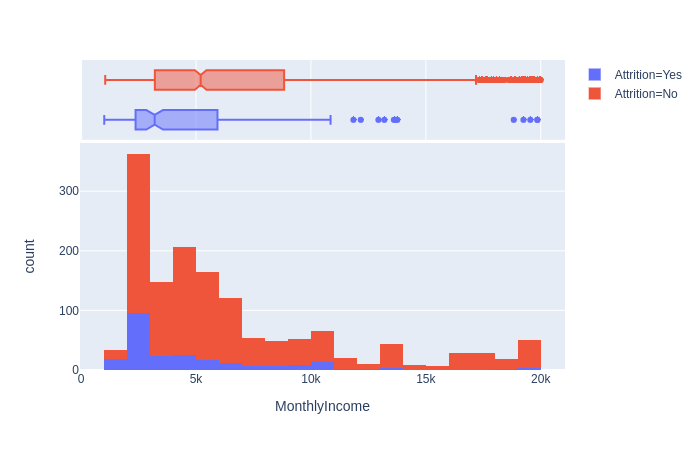

In [113]:
#@title Distribuição dos dados

feature = 'MonthlyIncome' #@param ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EnvironmentSatisfaction', 'HourlyRate','JobInvolvement', 'JobLevel', 'JobSatisfaction','MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating','RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel','TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance','YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion','YearsWithCurrManager']
split_by= 'Attrition' #@param ['Attrition', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction','PerformanceRating','RelationshipSatisfaction']

fig = px.histogram(df, 
       x=feature,
       marginal = 'box',
       hover_data = ['EmployeeNumber', 'Age', 'Gender'],
       color = split_by
      )

fig.show('png')

A primeira informação importante é que não foi identificado nenhum outlier que devesse ser removido. Naturalmente existem outliers nos dados mas eles aparentam fazer parte da distribuição e nenhum valor ilógico foi encontrado.

Diversas teorias e conclusões podem ser registradas com esses dados:


1. `Age` - Idade

  Existe uma pequena diferença entre a distribuição dos funcionários que tiveram atritos dos que não os tiveram em termos de idade. Uma possível teoria é de que pessoas mais jovens possuem uma tendência maior a terem desentendimentos. As causas podem ser falta de experiência na atividade, salários baixos, dificuldade de se adaptar ao ambiente de uma empresa, maior disposição a aceitar riscos, entre outras. Porém a idade não parece ser um fator influente nos resultados de satisfação com o trabalho, uma vez que as distribuições são similares.

2. `Education` - Educação

  O nível de educação dos colaboradores não apresentou efeito significativo nas variáveis de interesse.

3. `MonthlyIncome` - Salário Mensal

  Os resultados de salário mensal e atrito possuem alguma relação aparente. Mas a questão principal é, se existe causalidade, quem é a causa e quem é a consequência? Pessoas com baixos salários acabam tendo mais desentendimentos ou pessoas que acabam tendo desentendimentos encontram dificuldades em chegar a posições mais bem pagas? Esse é o tipo de informação que poderia ser obtida caso houvesse um registro temporal dos dados. Falando de satisfação no trabalho, o salário não teve efeitos significativos (um resultado que é bastante relevante, se pensarmos com calma).

4. `NumCompaniesWorked` - Número de empresas trabalhadas

  Apesar de as medianas estarem levemente deslocadas para os resultados de atritos e satisfação, não existe diferença prática entre as distribuições que pudesse alimentar alguma teoria.

5. `TotalWorkingYears` - Total de anos de carreira

  Nos gráficos é possível identificar que a maior parte dos funcionários que possuíram atritos estão no primeiro ano de suas carreiras. Isso significa que na realidade a variável `Attrition` não está relacionada a se o funcionário já teve qualquer desentendimento no passado. Ela é uma métrica de curto prazo, que avalia por exemplo se o funcionário teve atrito no último ano, caso contrário o resultado do gráfico seria muito improvável.
  
  Além disso é possível notar um pico na quantidade de funcionários com 10 anos de carreira, que parece ser não-natural. Uma das teorias para que aquilo ocorresse é se na verdade os dados disponíveis foram coletados apenas com alguns funcionários da empresa, e o time de RH quisesse fazer uma análise mais específica dos funcionários com 10 anos de carreira. Outra possibilidade é que houve algum problema na hora de coletar ou inserir os dados no sistema, e o que deveria ser 1 ano de carreira (ou seja, os funcionários que começaram recentemente) acabou aparecendo como 10.
  Assim como visto na distribuição por idade, funcionários que começaram a carreira há pouco tempo apresentaram mais conflitos no local de trabalho, mas isso não impactou os resultados de satisfação com o trabalho.
  

6. `WorkLifeBalance` - Equilíbrio entre vida pessoal e profissional

  Os resultados da pesquisa de equilíbrio entre vida pessoal e profissional não tiveram muito impacto nas outras variáveis de interesse, o que é um pouco estranho. Não é esperado que um funcionário que sinaliza que está trabalhando demais diga que está tão satisfeito quanto um que acha que trabalha menos. 

7. `YearsAtCompany`, `YearsInCurrentRole`, `YearsSinceLastPromotion`,  `YearsWithCurrManager`

  Essas quatro variáveis mostram distribuições similares entre si. Aparentemente quanto mais tempo um colaborador permanece na empresa, na mesma posição e com o mesmo líder, menores as chances de ele possuir um desentendimento. Todas essas variáveis podem ser traduzidas com uma estabilidade no trabalho, o que é visto como bom de uma perspectiva de redução de conflitos. 
  O que é surpreendente é a quantidade de pessoas promovidas recentemente pela empresa. Mais de 50% de todos os funcionários do dataset foram promovidos no ano da coleta dos dados ou no ano anterior, o que não é comum em empresas deste porte. É possível identificar que colaboradores recentemente promovidos acabam tendo mais desentendimentos, provavelmente devido a mudanças de cargo, time ou líder.
  
  Nenhuma dessas variáveis tiveram um impacto significativo nos resultados de satisfação com o trabalho.


In [114]:
df.describe(include='O')

,Attrition,BusinessTravel,Department,EducationField,EmployeeNumber,Gender,JobRole,MaritalStatus,Over18,OverTime
count,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,6,1470,2,9,3,1,2
top,No,Travel_Rarely,Research & Development,Life Sciences,2046,Male,Sales Executive,Married,Y,No
freq,1233,1043,961,606,1,882,326,673,1470,1054


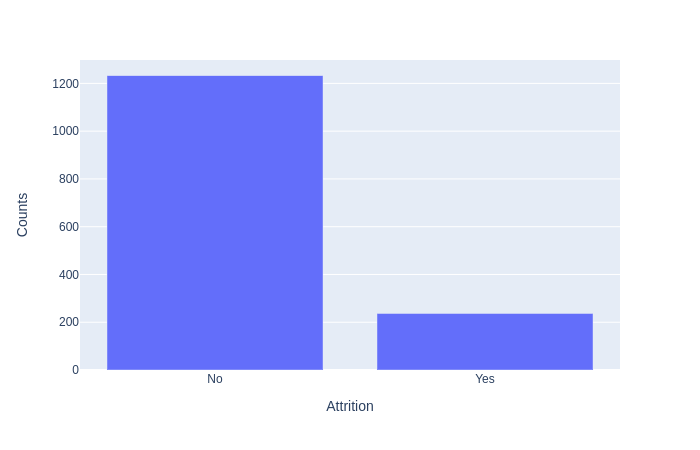

In [115]:
#@title Distribuição dos dados categóricos


feature = 'Attrition' #@param ['Attrition',	'BusinessTravel',	'Department',	'EducationField',	'Gender',	'JobRole',	'MaritalStatus',	'Over18',	'OverTime']


counts = pd.DataFrame(df[feature].value_counts())

fig = px.bar(counts, 
       x=counts.index, 
       y=feature,
       labels = {
           feature:'Counts',
           'x':feature
       })

fig.show('png')

Algumas das conclusões que são possíveis a partir dos dados categóricos:


1. Menos de 20% dos funcionários tiveram desentendimentos recentemente. Se isso é um resultado bom ou ruim depende muito do que a empresa está classificando como atrito, mas definitivamente existe margem para melhora nos números.

2. A maior parte dos funcionários possui ensino superior nas área de ciências da saúde e medicina, e ocupa posições de Pesquisa e Desenvolvimento e Vendas.

3. Existe um número bastante significativo de chefes e diretores comparado ao número total de colaboradores. Isso reforça a teoria de que nem todos os funcionários responderam à pesquisa, ou houve uma seleção de uma parte dos funcionários na hora da coleta de dados.

Mais análises dos dados categóricos serão realizadas uma vez que o modelo de agrupamento for criado.


## Modelo de Classificação

Esta seção é dedicada à aplicação de um modelo de classificação ao problema. Esse modelo é alimentado com dados da pesquisa de clima, para identificar padrões dos funcionários que tiveram conflitos recentemente. Assim quando o modelo recebe novos dados ele consegue identificar padrões similares e estimar a probabilidade que determinado funcionário tem de ter um conflito. 

Note que existem variações nos resultados obtidos com os modelos toda vez que o código é executado, portanto se você executar o código pode encontrar valores que não correspondem exatamente àqueles que eu mencionarei.


### Seleção das variáveis relevantes

Até este ponto o dataset não foi "filtrado" nenhuma vez, portando existem variáveis que não possuem significado prático ou não são de interesse para o objetivo do projeto. Para evitar que essas variáveis influenciem no modelo elas serão removidas do dataset.

In [116]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [117]:
dfML = df.copy()

dfML.drop(['DailyRate', 'EmployeeCount','EmployeeNumber', 'HourlyRate','JobLevel', 'MonthlyRate', 'Over18', 'StandardHours', 'StockOptionLevel'], axis=1, inplace=True)

dfML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   Department                1470 non-null   object
 4   DistanceFromHome          1470 non-null   int64 
 5   Education                 1470 non-null   int64 
 6   EducationField            1470 non-null   object
 7   EnvironmentSatisfaction   1470 non-null   int64 
 8   Gender                    1470 non-null   object
 9   JobInvolvement            1470 non-null   int64 
 10  JobRole                   1470 non-null   object
 11  JobSatisfaction           1470 non-null   int64 
 12  MaritalStatus             1470 non-null   object
 13  MonthlyIncome             1470 non-null   int64 
 14  NumCompaniesWorked      

### Transformação das variáveis categóricas

O segundo passo na preparação do dataset é a conversão das variáveis categóricas em numéricas para que o modelo consiga considerá-las em sua análise.

In [118]:
dfML = pd.get_dummies(dfML)

dfML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 48 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   DistanceFromHome                   1470 non-null   int64
 2   Education                          1470 non-null   int64
 3   EnvironmentSatisfaction            1470 non-null   int64
 4   JobInvolvement                     1470 non-null   int64
 5   JobSatisfaction                    1470 non-null   int64
 6   MonthlyIncome                      1470 non-null   int64
 7   NumCompaniesWorked                 1470 non-null   int64
 8   PercentSalaryHike                  1470 non-null   int64
 9   PerformanceRating                  1470 non-null   int64
 10  RelationshipSatisfaction           1470 non-null   int64
 11  TotalWorkingYears                  1470 non-null   int64
 12  TrainingTimesLastYea

In [119]:
dfML

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1,2,2,3,4,5993,8,11,3,1,8,0,1,6,4,0,5,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
1,49,8,1,3,2,2,5130,1,23,4,4,10,3,3,10,7,1,7,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0
2,37,2,2,4,2,3,2090,6,15,3,2,7,3,3,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,33,3,4,4,3,3,2909,1,11,3,3,8,3,3,8,7,3,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,27,2,1,1,3,2,3468,9,12,3,4,6,3,3,2,2,2,2,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,23,2,3,4,4,2571,4,17,3,3,17,3,3,5,2,0,3,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1466,39,6,1,4,2,1,9991,4,15,3,1,9,5,3,7,7,1,7,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1467,27,4,3,2,4,2,6142,1,20,4,2,6,0,3,6,2,0,3,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1468,49,2,3,4,2,2,5390,2,14,3,4,17,3,2,9,6,0,8,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0


### Separação dos dados de treino e teste

É necessário informar ao modelo qual é a variável que ele precisará prever, e quais as variáveis são usadas para que ele faça a análise. Esses dois grupos são chamados comumente de X e Y, respectivamente.

O objetivo é prever conflitos, portanto a variável `Attrition` será a resposta que buscamos, e as outras variáveis podem ser utilizadas para alimentar o modelo.

Alem disso é importante separar uma parte dos dados para realizar uma verificação da qualidade do modelo após o treinamento. Esses dados não serão utilizados na etapa de treinamento e serão mostrados como dados novos uma vez que ele estiver pronto.


In [120]:
# Create a matrix of input variables X and results array Y

X = dfML.drop(['Attrition_No', 'Attrition_Yes'], axis=1)
Y = dfML.Attrition_Yes

# Create train and test datasets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(dfML.shape)

(1176, 46)
(294, 46)
(1176,)
(294,)
(1470, 48)


### Normalização

Variáveis numéricas possuem diferentes escalas de variação. Pela maneira que alguns modelos são construídos, essas escalas podem impactar na relevância que cada variável possui no modelo, prejudicando os resultados estimados. Para evitar esse tipo de efeito iremos colocar todas as variáveis em escalas aproximadas.


In [121]:
# Normalize inputs X

scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

X_train_norm

array([[ 0.1411209 ,  0.82727069,  0.08242928, ...,  1.46437189,
         0.6219264 , -0.6219264 ],
       [ 0.36225105,  0.09505519,  1.0517976 , ..., -0.68288664,
        -1.60790729,  1.60790729],
       [-0.85396478, -0.75919623, -1.85630737, ...,  1.46437189,
        -1.60790729,  1.60790729],
       ...,
       [-1.18566001, -1.00326807, -1.85630737, ..., -0.68288664,
         0.6219264 , -0.6219264 ],
       [ 0.69394628, -0.02698073,  0.08242928, ...,  1.46437189,
         0.6219264 , -0.6219264 ],
       [ 0.03055582, -1.00326807,  1.0517976 , ..., -0.68288664,
         0.6219264 , -0.6219264 ]])

Agora possuímos um dataset normalizado para treinar o modelo.

### Seleção do Modelo

Existem muitos modelos de Machine Learning que podem ser aplicados a um problema de classificação. Existem diretrizes gerais de quando utilizar cada um deles, mas é muito recomendado que mais de um seja testado para encontrar aquele que melhor se encaixa às particularidades dos dados. 

Iremos testar alguns modelos para definir qual deles iremos utilizar na previsão dos resultados.


In [122]:
def val_model(X, y, classifier, scor, show):

  X = np.array(X)
  y = np.array(y)

  # pipeline = make_pipeline(StandardScaler(), classifier)
  # scores = cross_val_score(pipeline, X, y, scoring = scor)

  scores = cross_val_score(classifier, X, y, scoring = scor)

  if show == True:
    print("Score: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
  
  return scores.mean()

In [123]:
# Create models
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
score = []

# Check score
for classifier in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(classifier.__class__.__name__)
    score.append(val_model(X_train_norm, Y_train, classifier, scor='recall', show=True))

pd.DataFrame(data=score, index=model, columns=['Recall'])

Score: 0.19 (+/- 0.04)
Score: 0.36 (+/- 0.06)
Score: 0.42 (+/- 0.07)
Score: 0.19 (+/- 0.04)
Score: 0.41 (+/- 0.08)
Score: 0.29 (+/- 0.05)
Score: 0.32 (+/- 0.05)


,Recall
RandomForestClassifier,0.194595
DecisionTreeClassifier,0.356757
SGDClassifier,0.416216
SVC,0.189189
LogisticRegression,0.405405
XGBClassifier,0.286486
LGBMClassifier,0.318919


Um ponto que não foi previamente discutido é a seleção da métrica de resultados. Essa parte será comentada em breve mas por agora basta mencionar que o score de Recall será utilizado. Essa métrica varia de 0 a 1, sendo 1 o melhor resultado, o que mostra que os resultados atuais dos modelos não estão bons.

Existe uma verificação importante a ser realizada. Como a grande maioria dos funcionários não teve conflitos recentemente, o dataset é considerado desbalanceado. Ao trabalhar com dados desbalanceados é possível que o modelo tenha mais dificuldades em detectar padrões da classe minoritária, que no nosso estudo são os casos de atrito que queremos identificar. É possível balancear artificialmente os dados de algumas maneiras, portanto iremos realizar esta prática e verificar se melhorias são identificadas.

(370, 46)
(370,)


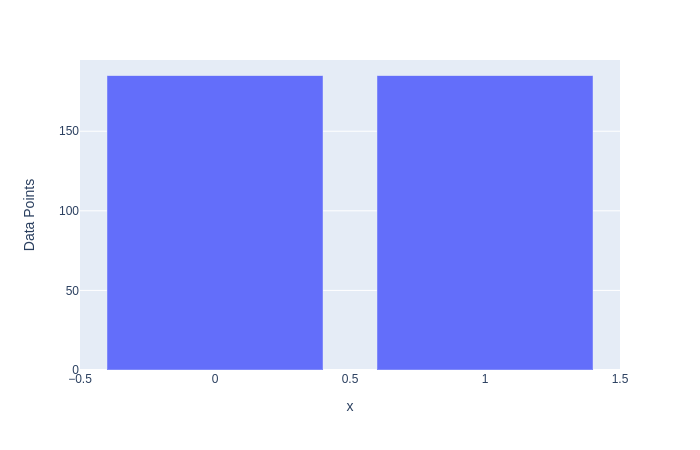

In [124]:
rus = RandomUnderSampler()
X_rus, Y_rus = rus.fit_sample(X_train, Y_train)
print(X_rus.shape)
print(Y_rus.shape)
df_rus = pd.DataFrame(Y_rus)
counts2 = pd.DataFrame(df_rus.loc[:,0].value_counts())
counts2.columns = ['Data Points']
fig = px.bar(counts2, x=counts2.index, y='Data Points' )

fig.show('png')

Com o balanceamento a quantidade de dados para alimentar o modelo reduz drasticamente. Agora iremos verificar se isso foi benéfico ou prejudicial para os resultados, mas antes é necessário normalizar novamente os dados originais, pois médias e desvio padrão podem ter mudado.


In [125]:
# Normalize inputs X

scaler_rus = StandardScaler()
scaler_rus.fit(X_rus)
X_rus_norm = scaler_rus.transform(X_rus)
X_test_rus_norm = scaler_rus.transform(X_test)

X_rus_norm

array([[ 0.74509737,  0.01575873,  1.11404904, ...,  1.15834889,
         0.7623625 , -0.7623625 ],
       [ 0.53966814, -0.34122479, -0.84413692, ...,  1.15834889,
         0.7623625 , -0.7623625 ],
       [-0.17933417, -0.81720281, -0.84413692, ...,  1.15834889,
         0.7623625 , -0.7623625 ],
       ...,
       [ 0.12880968,  0.01575873,  1.11404904, ...,  1.15834889,
         0.7623625 , -0.7623625 ],
       [-0.28204878,  0.49173676,  0.13495606, ..., -0.86329776,
        -1.31171195,  1.31171195],
       [ 0.02609506,  0.72972577,  1.11404904, ...,  1.15834889,
         0.7623625 , -0.7623625 ]])

In [126]:
# Create models
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model_rus = []
score_rus = []

# Check score
for classifier in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model_rus.append(classifier.__class__.__name__)
    score_rus.append(val_model(X_rus_norm, Y_rus, classifier, scor='recall', show=True))

pd.DataFrame(data=score_rus, index=model_rus, columns=['Recall RUS'])

Score: 0.67 (+/- 0.08)
Score: 0.61 (+/- 0.05)
Score: 0.70 (+/- 0.11)
Score: 0.74 (+/- 0.05)
Score: 0.78 (+/- 0.04)
Score: 0.74 (+/- 0.06)
Score: 0.72 (+/- 0.07)


,Recall RUS
RandomForestClassifier,0.670270
DecisionTreeClassifier,0.610811
SGDClassifier,0.697297
SVC,0.740541
LogisticRegression,0.783784
XGBClassifier,0.735135
LGBMClassifier,0.718919


O resultado de Recall melhorou significativamente utilizando os dados balanceados. Agora podemos escolher o modelo com qual trabalhar para prever os resultados. Escolherei o modelo LGBMClassifier por sua diversidade de parâmetros que podem ser ajustados para melhorar os resultados.

### Ajuste de Hiperparâmetros

Modelos de Machine Learning possuem parâmetros importantes que definem como eles aprendem e prevêm resultados. Diferentes parâmetros geram diferentes modelos e consequentemente diferentes resultados. Devido à complexidade dos modelos não existe uma maneira analítica fácil de definir a combinação ideal de parâmetros para cada problema. O ajuste de hiperparâmetros então pode ser realizado de maneira iterativa usando a velocidade de processamento do computador, que testa diversas combinações e retorna a melhor delas para que seja utilizada.

Vamos testar diversas combinações para tentar encontrar melhores resultados na previsão do modelo. O significado destes parâmetros não será abordado neste artigo mas pode ser encontrado neste [material](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html).

In [127]:
lgbm = LGBMClassifier()

param_grid = {
    'learning_rate':[0.001, 0.01, 0.1, 1],
    'max_depth':[2, 4, 6, 8, 10],
    'num_leaves':[1, 2, 4, 8, 16, 32, 64, 128],
    'min_data_in_leaf':range(0, 500, 50)
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(lgbm, param_grid, scoring='recall', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_rus_norm, Y_rus)

print('Best score: {} for {}'.format(grid_result.best_score_, grid_result.best_params_))

Best score: 0.7953216374269005 for {'learning_rate': 1, 'max_depth': 2, 'min_data_in_leaf': 0, 'num_leaves': 2}


Os resultados melhoraram significativamente com o ajuste. Agora é possível treinar o modelo com a melhor combinação e testá-lo com os dados de teste.


### Validação do Modelo

Esta é a etapa em que o modelo criado é testado e sua acurácia é analisada. Para isso utilizaremos reports de classificação e matrizes de confusão.


              precision    recall  f1-score   support

           0       0.93      0.71      0.81       242
           1       0.36      0.75      0.48        52

    accuracy                           0.72       294
   macro avg       0.64      0.73      0.65       294
weighted avg       0.83      0.72      0.75       294



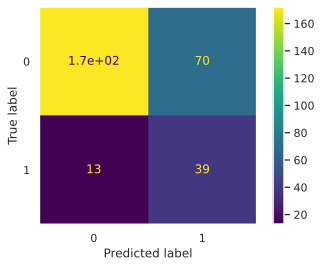

In [145]:
lgbm = LGBMClassifier(learning_rate=1, max_depth=2, min_data_in_leaf=0, num_leaves=2)
lgbm.fit(X_rus_norm, Y_rus)

Y_pred = lgbm.predict(X_test_rus_norm)

print(classification_report(Y_test, Y_pred))

plot_confusion_matrix(lgbm, X_test_rus_norm, Y_test)
plt.show()


Apesar dos resultados satisfatórios de recall, o report de classificação mostra uma precisão de 0.36 para a classe 1. Mas o que isso significa?


* Precisão - Uma precisão de 0.36 significa que quando o modelo prevê que um funcionário terá um conflito, em apenas 36% das vezes ele estará certo e em 64% dos casos isso será um falso positivo.

* Recall - Um recall de 0.75 significa que o modelo vai conseguir identificar 75% de todos os casos de atrito que acontecerão, e 25% deles não serão previamente identificados.

Esses conceitos são um pouco confusos portanto sugiro que leia novamente com calma caso não tenha compreendido.

Um valor de precisão tão pequeno vai gerar muitos falsos positivos que irão custar muitas horas e custas de projetos do time de RH. Portanto é necessário melhorar esse resultado e a melhor maneira de fazer isso é analisando a curva de precisão e recall.

Como previamente mencionado, modelos de classificação na realidade calculam a probabilidade de que um dado pertença a uma ou outra classe, e com base em uma probabilidade de referência definem a classe prevista daquele dado. Por exemplo, se a probabilidade de referência é 50% e o modelo estimar que existe 51% de probabilidade que um funcionário ter um conflito, ele vai classificar o colaborador no grupo de atrito. Porém se estipularmos para que o modelo apenas classifique como atrito os funcionários que tiverem mais de 75% ou 80% de probabilidade por exemplo, a quantidade de alarmes falsos irá diminuir.

Se não definirmos uma probabilidade de referência o modelo acaba escolhendo por si mesmo, e em muitos problemas esse valor não é o ideal. Em uma curva de precisão e recall é possível observar o resultado dessas duas métricas para diferentes probabilidades de referência e então escolher aquela que entrega os melhores resultados para determinado objetivo. Vamos fazer isso.


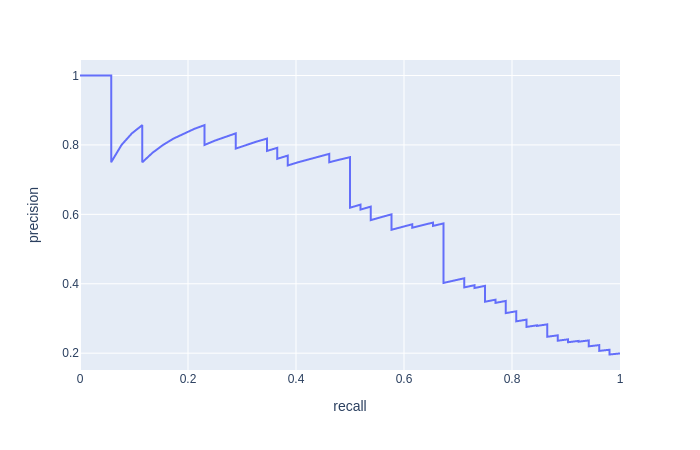

In [146]:

Y_proba = lgbm.predict_proba(X_test_rus_norm)
# Y_proba_unb = xgb_unb.predict_proba(X_test)

# Keep probabilities for the positive outcome only
Y_proba = Y_proba[:, 1]

# Create a dataframe with precision and recall for each threshold
curve = pd.DataFrame(precision_recall_curve(Y_test, Y_proba)).transpose()
curve.columns = ['precision', 'recall', 'threshold']

# print(curve)

# Create a precision and recall curve to see the results for different thresholds
fig = px.line(curve, x='recall', y='precision', hover_data=['threshold'])

fig.show('png')

Podemos ver que alguns valores melhoram um pouco os resultados das métricas, mas antes de alterar a referência irei fazer uma segunda análise.

Uma outra opção para tentar obter um resultado melhor é trabalhar com o dataset original desbalanceado. Em muitos casos a redução do volume de dados é muito alta em um processo de balanceamento e acaba prejudicando mais o modelo do que ajudando. Utilizarei o modelo com os mesmos parâmetros apenas para fins de explicação mas o ideal é realizar o processo de ajuste de hiperparâmetros novamente.

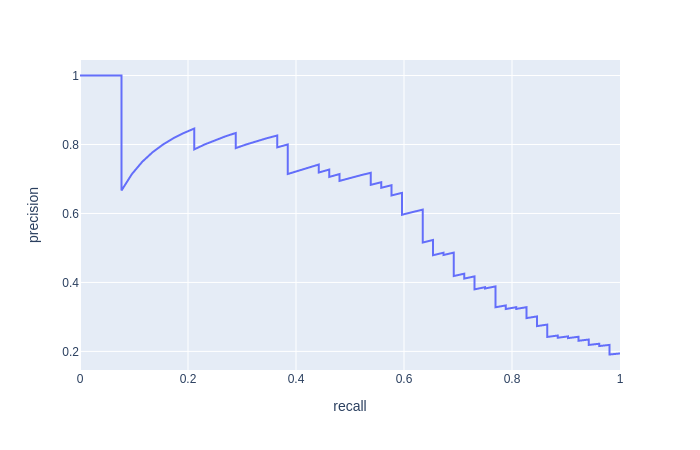

In [164]:
# Create model for unbalanced dataset

lgbm_unb = LGBMClassifier(learning_rate=1, max_depth=2, min_data_in_leaf=0, num_leaves=2)
lgbm_unb.fit(X_train_norm, Y_train)

Y_pred_unb = lgbm_unb.predict(X_test_norm)


Y_proba_unb = lgbm_unb.predict_proba(X_test_norm)

# Keep probabilities for the positive outcome only
Y_proba_unb = Y_proba_unb[:, 1]

# Create a dataframe with precision and recall for each threshold
curve = pd.DataFrame(precision_recall_curve(Y_test, Y_proba_unb)).transpose()
curve.columns = ['precision', 'recall', 'threshold']

# print(curve)

# Create a precision and recall curve to see the results for different thresholds
fig = px.line(curve, x='recall', y='precision', hover_data=['threshold'])

fig.show('png')

Com o dataset original foram encontradas melhores combinações de precisão e recall na curva em algumas regiões de interesse. Vamos escolher a probabilidade de referência de 38% e testar o dataset novamente.


In [163]:
y_pred_adj = (lgbm_unb.predict_proba(X_test_norm)[:,1] >= 0.38).astype(bool) # set threshold as 0.38

print(classification_report(Y_test, y_pred_adj))


              precision    recall  f1-score   support

           0       0.91      0.93      0.92       242
           1       0.66      0.60      0.63        52

    accuracy                           0.87       294
   macro avg       0.79      0.77      0.78       294
weighted avg       0.87      0.87      0.87       294



Com a nova referência foi possível encontrar um resultado mais equilibrado entre precisão e recall, e melhorar a acurácia absoluta do modelo. Isso significa que terão menos falsos positivos, mas também terão alguns casos que passarão despercebidos pelo modelo. Mas o benefício no resultado de precisão do modelo vale a pena neste caso.

Em resumo diferentes opções estão disponíveis e é possível ajustar as referências para se ter um modelo mais rígido ou mais flexível em termos de detecção de atritos.


## Modelo de Clusterização

Com o modelo de classificação conseguimos prever casos de atritos e agir antes que eles aconteçam para melhorar as relações e união dos times dentro da empresa. Porém isso não é a resposta para todos os problemas. Existem questões que esse modelo não consegue responder, como por exemplo:

* O que fazer com funcionários que tiveram conflitos?

* Quem são as referências da empresa em bons relacionamentos e quais as diferenças que esses grupos possuem?

* Existe alguma forma de proteger os melhores talentos e a alta liderança de problemas críticos de relacionamento?

Para desenvolver estratégias mais assertivas para cada colaborador é possível criar grupos baseados nesses perfis, identificando diferenças significativas entre eles e estabelecendo diferentes estratégias para lidar com a carreira de cada um. Vamos fazer isso e ver o que conseguimos encontrar com os dados disponíveis.

### Seleção de Variáveis

O primeiro ponto importante é definir quais são as variáveis relevantes para que o modelo seja treinado. É importante escolher um número suficiente para definir perfis de colaboradores, mas se incluírmos muitos o modelo pode perder significância prática.

Dessa forma iremos escolher a variável de atritos e os resultados da pesquisa de clima e de performance deles. Para criar os clusters novamente é importante que os dados estejam em formato numérico, portanto começamos a análise realizando essa transformação.


In [14]:
# allowing all the columns to be visualized
pd.options.display.max_columns = None

dfML = df[['Attrition', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']].copy()

# dfML.drop(['DailyRate', 'EmployeeCount','EmployeeNumber', 'HourlyRate','JobLevel', 'MonthlyRate', 'Over18', 'StandardHours', 'StockOptionLevel'], axis=1, inplace=True)

dfMLdum = pd.get_dummies(dfML)
dfMLdum.drop(['Attrition_No'],axis=1,inplace=True)
dfMLdum

,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance,Attrition_Yes
0,2,3,4,3,1,1,1
1,3,2,2,4,4,3,0
2,4,2,3,3,2,3,1
3,4,3,3,3,3,3,0
4,1,3,2,3,4,3,0
...,...,...,...,...,...,...,...
1465,3,4,4,3,3,3,0
1466,4,2,1,3,1,3,0
1467,2,4,2,4,2,3,0
1468,4,2,2,3,4,2,0


Então é novamente necessário colocar os dados na escala apropriada. Estamos repetindo este processo pois pegamos os dados originais do dataset para começar este novo modelo.


In [15]:
scaler = StandardScaler()
dfMLstd = scaler.fit_transform(dfMLdum)
dfMLstd

array([[-0.66053067,  0.37967213,  1.15325359, ..., -1.58417824,
        -2.49382042,  2.28090588],
       [ 0.25462493, -1.02616674, -0.66085318, ...,  1.19143799,
         0.33809616, -0.4384223 ],
       [ 1.16978053, -1.02616674,  0.2462002 , ..., -0.65897283,
         0.33809616,  2.28090588],
       ...,
       [-0.66053067,  1.78551099, -0.66085318, ..., -0.65897283,
         0.33809616, -0.4384223 ],
       [ 1.16978053, -1.02616674, -0.66085318, ...,  1.19143799,
        -1.07786213, -0.4384223 ],
       [-0.66053067,  1.78551099,  0.2462002 , ..., -1.58417824,
         1.75405446, -0.4384223 ]])

### Redução de Dimensionalidade

Agora que as variáveis possuem escalas similares podemos realizar uma redução de dimensionalidade utilizando PCA (Principal Component Analysis), para aumentar a velocidade do modelo de clusterização e melhorar a visualização dos grupos de dados posteriormente.

Para definir quantos componentes serão utilizados é importante verificar os resultados de variação explicada deles. Portanto vamos reduzir a dimensionalidade e analisar a melhor quantidade de componentes.

In [16]:
pca = PCA()
pca.fit(dfMLstd)
pca

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

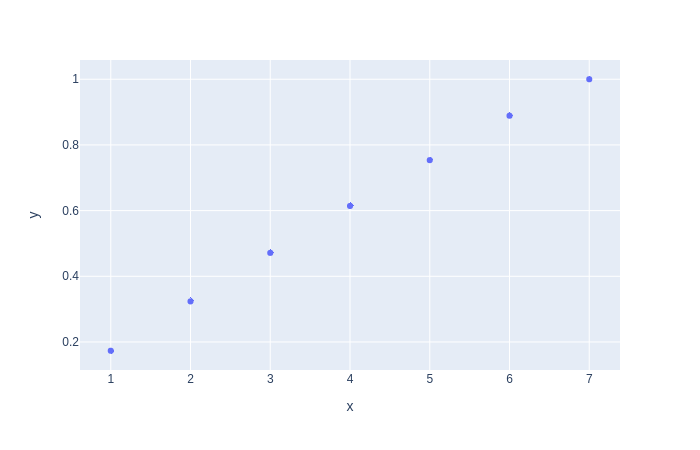

In [17]:
fig = px.scatter(
    x = range(1,8), 
    y = pca.explained_variance_ratio_.cumsum()
)

fig.show('png')

Esse comportamento linear dos resultados mostra que não é possível explicar toda a variação existente utilizando somente um ou dois componentes. Nessa situação a redução de dimensionalidade deixa de ser uma alternativa muito benéfica pois teremos que utilizar uma quantidade muito parecida de componentes, mas vamos realizar mesmo assim para este exemplo.


In [18]:
pca = PCA(n_components=6)
pca.fit(dfMLstd)
scorespca = pca.transform(dfMLstd)

### Clusterização

Com o número de componentes principais definido, é hora de aplicar o modelo de clusterização. Assim como no PCA, não sabemos qual o número ideal de clusters para agrupar os colaboradores. Naturalmente é preciso que seja um número razoável para que o time de RH consiga de fato realizar tratativas diferentes para cada grupo, mas ainda existe uma certa flexibilidade nesse valor. Portanto podemos utilizar um método chamado "Elbow Method" e testar a qualidade do modelo com quantidades de 1 a 10 grupos, para definir um bom número. Essa qualidade é avaliada a partir de uma métrica chamada Within Cluster Sum of Squares (WCSS).


In [19]:

wcss = []
for i in range (1, 10):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10)
  kmeans.fit(scorespca)
  wcss.append(kmeans.inertia_)




Com os resultados capturados é possível plotá-los em um gráfico e buscar um resultado baixo de WCSS.

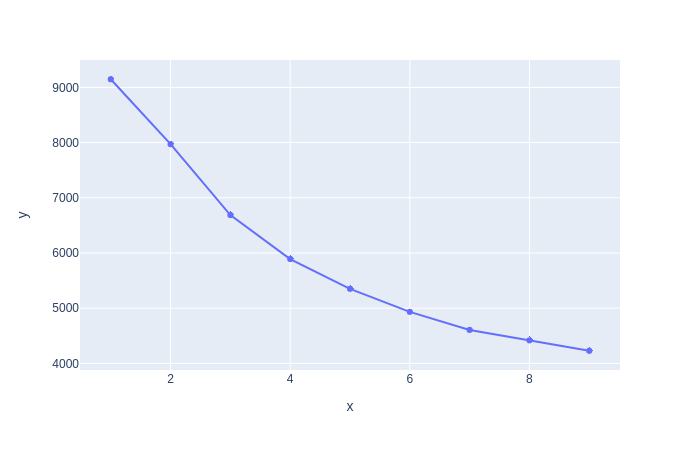

In [20]:
fig = px.scatter(
    x=range(1,10),
    y=wcss,
)

fig.update_traces(mode='markers+lines')
fig.show('png')

Uma vez que não existe um valor de clusters no qual o benefício incremental reduz drasticamente (chamado informalmente de joelho, ou cotovelo no gráfico) a decisão passa a ser mais prática do que técnica. Vamos escolher 4 grupos para prosseguir. 

In [21]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10)
kmeans.fit(scorespca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

### Análise dos Agrupamentos

Com o modelo criado e treinado é possível agrupar as informações dos funcionários com os grupos nos quais eles foram alocados a partir de seus comportamentos. 

In [22]:
dfpca = pd.DataFrame(scorespca)
dfClusters = pd.concat([dfML, dfpca], axis=1) 
dfClusters.columns.values[-6:] = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
dfClusters['Clusters'] = kmeans.labels_
dfClusters

,Attrition,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance,PC1,PC2,PC3,PC4,PC5,PC6,Clusters
0,Yes,2,3,4,3,1,1,2.286289,0.820560,-2.313658,-1.565529,0.815479,-0.172240,2
1,No,3,2,2,4,4,3,0.177376,0.425147,1.134580,1.743134,-0.506709,1.918954,3
2,Yes,4,2,3,3,2,3,1.550333,0.131707,1.342675,-1.345244,0.104729,-0.044301,2
3,No,4,3,3,3,3,3,-1.170903,-0.134403,0.482299,-0.522554,0.203667,0.170734,0
4,No,1,3,2,3,4,3,-0.173228,-1.269541,-0.676698,0.923029,-1.092484,-0.462070,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,No,3,4,4,3,3,3,-1.656786,0.037275,-0.909724,0.061123,-0.015548,-0.569114,0
1466,No,4,2,1,3,1,3,0.358040,-0.119681,1.742891,-0.732771,1.687785,-0.342815,1
1467,No,2,4,2,4,2,3,-0.210453,0.398288,-0.639925,2.752365,1.420781,0.077255,3
1468,No,4,2,2,3,4,2,-0.266629,-0.692339,0.454244,-1.159048,-0.214566,1.726569,0


Podemos visualizar os agrupamentos de colaboradores em gráficos de dispersão 2D e 3D para buscar algumas informações. Se utilizarmos os componentes principais do PCA como eixos as diferenças entre os grupos ficam mais evidentes mas o gráfico perde significância prática.


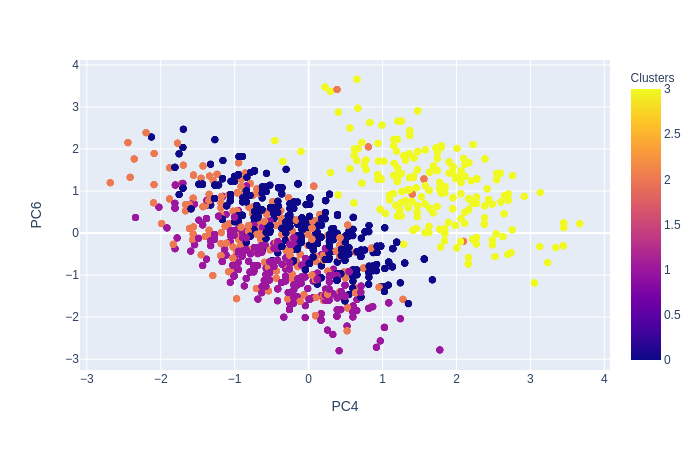

In [23]:
fig = px.scatter(dfClusters,
           x= 'PC4',
           y= 'PC6',
           color = 'Clusters',
          #  hover_data=['MonthlyIncome']
)

fig.show('png')

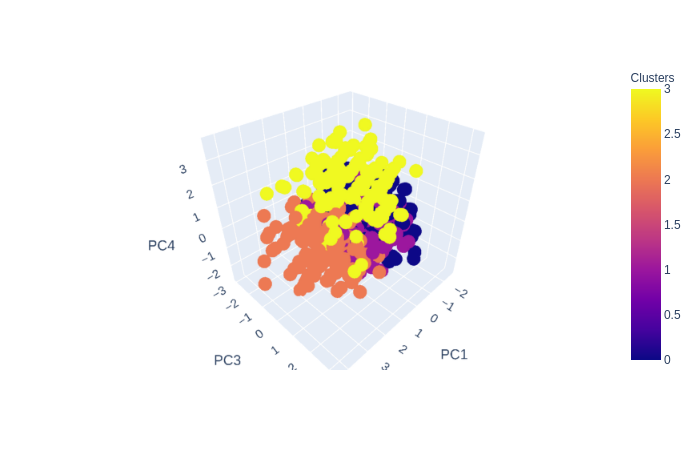

In [24]:
fig = px.scatter_3d(dfClusters,
           x= 'PC1',
           y= 'PC3',
           z= 'PC4',
           color = 'Clusters',
          #  hover_data=['MonthlyIncome']
)

fig.show('png')

Na representação alguns grupos parecem misturados, mas isso não é uma realidade. Para conseguir visualizar os resultados precisamos representar resultados multidimensionais em 2D ou 3D, o que pode gerar essa impressão de que estão misturados. Mas no espaço multidimensional eles possuem suas diferenças claras.

Para encontrar essas diferenças e identificar os perfis dos funcionários de cada agrupamento podemos utilizar diversos métodos. Um dos métodos se chama análise de categorias paralelas e permite que vejamos um resumo do comportamento desses agrupamentos em diversas variáveis.

Nesses gráficos a altura da barra de cada cor representa quanto do total de dados de uma determinada variável é composta por um determinado cluster. Ou seja, quando vemos abaixo a maior parte da categoria `Yes` na cor laranja em `Attrition` significa que a maior parte dos funcionários que tiveram conflitos pertencem ao agrupamento da cor laranja (identificado por um número no final do gráfico).

OBS: Este gráfico não é visível no GitHub. Para visualizá-lo você deve acessar o Notebook do Google Colab no início deste artigo ou neste [link](https://colab.research.google.com/drive/1VsMQZQwWWhOdia4D47nZAM5BuyPsCAoa?usp=sharing).

In [26]:
fig = px.parallel_categories(dfClusters, width = 2000, color='Clusters')


py.iplot(fig)

Podemos ver a partir dos dados que existem diferenças bastante claras entre os grupos:


1. O grupo 2 (laranja) é composto principalmente por pessoas que tiveram desentendimentos recentemente. Esses são os colaboradores que o RH deve atingir com medidas de redução de danos, para resolver os conflitos. Nenhum dos funcionários deste grupo deu um score máximo para envolvimento com o trabalho, o que pode ser um indício que eles estão desconectados com a empresa, e não vêem muito propósito em suas atividades, ou simplesmente estão desmotivados.

2. O grupo 3 (amarelo) é o grupo dos funcionários de alta performance. Estes podem ser considerados os verdadeiros talentos da companhia, aqueles que ela não deseja perder sob nenhuma circunstância. Uma pequena parte das pessoas deste grupo teve conflitos recentemente e não estão satisfeitos com seus relacionamentos no trabalho. Portanto é necessário que um trabalho mais dedicado seja realizado para resolver esses impasses e mantê-los engajados e motivados. Mudança de cargos, mediação de conflitos são algumas das opções.

3. O grupo 0 (azul) é composto pelos funcionários que possuem bom relacionamento na empresa. Eles não tiveram atritos recentemente e deram scores altos para sua percepção dos relacionamentos na empresa. Naturalmente existem outros pontos de insatisfação que podem ser melhorados, mas como o objetivo da análise é em relacionamentos não entraremos em detalhes. 

4. O grupo 1 (roxo) é a zona de atenção. Esses funcionários não tiveram conflitos recentemente mas deram scores baixos em sua percepção de relacionamentos na companhia. Isso significa que estão desconfortáveis com suas relações e provavelmente terão atritos se nada for feito para ajudá-los.

Para resumir, o grupo 0 é a referência, onde os relacionamentos estão indo bem. O grupo 1 é a zona de atenção, onde um bom trabalho da equipe de RH vai realmente reduzir as taxas de conflitos. O grupo 3 é o grupo de alta performance, que em geral está bem em termos de relacionamentos, mas alguns casos específicos precisam ser tratados para evitar que os conflitos que ocorreram sejam causadores de um desligamento indesejado. E o grupo 2 é o grupo dos funcionários que mais tiveram desentendimentos recentemente. Esse é o grupo no qual uma estratégia de minimização de danos pode ser aplicada para melhorar a performance e o bem estar desses colaboradores.

Agora que os perfis estão bem definidos podemos investigar as informações mais gerais dos funcionários e ver se existem padrões interessantes detectados nos grupos.


In [27]:
dfFull = pd.concat([df, dfpca], axis=1) 
dfFull.columns.values[-2:] = ['PC1', 'PC2']
dfFull['Clusters'] = kmeans.labels_
dfFull.drop(['EmployeeCount', 'JobLevel', 'Over18', 'StandardHours', 'StockOptionLevel'], axis=1, inplace=True)

fig = px.parallel_categories(dfFull, width = 3000, color='Clusters')

py.iplot(fig)

Existe uma quantidade massiva de dados para analisar, então é importante que isso seja feito com atenção para identificar padrões. Em geral os grupos estão bem distribuídos em termos de dados demográficos, mas algumas conclusões podem ser realizadas:


1. O grupo de alta performance teve um claramente um aumento mais significativo de salário, o que mostra que a companhia baseia seus aumentos em performance. Também é possível perceber que os funcionários que tiveram mais conflitos tiveram os aumentos mais baixos. Seriam os aumentos mais baixos a causa de uma insatisfação que culminou em um desentendimento? Ou os conflitos foram de certa maneira repreendidos com um aumento mais baixo?

2. A maior parte dos colaboradores de posições hierárquicas mais altas não tiveram muitos atritos recentemente, mas muitos deles estão no grupo de atenção. Isso é um alerta que precisa ser levado em consideração.

Para concluir essa seção, todos os funcionários foram devidamente agrupados e o time de RH possui bastante informação sobre cada um deles para desenvolver estratégias por grupo de pessoas.



# Conclusão

Neste notebook realizei a análise de dados fictícios de RH criados pela IBM e criei dois modelos de Machine Learning a partir deles. 

Bastante informação sobre os padrões de comportamento dos funcionários foi capturada já na etapa de análise exploratória. O modelo classificador criado prevê com acurácia razoável quando um conflito irá acontecer. O modelo de clusterização agrupou os funcionários a partir de seus perfis ou de seus sentimentos com relação à empresa neste momento.

Esta análise é o ponto de partida para diferentes estratégias e projetos dentro de uma companhia, dependendo de quais objetivos se deseja atingir. É importante ressaltar que os dados utilizados não são difíceis de obter. Departamentos de RH já possuem informações básicas sobre seus funcionários e muitos deles aplicam pesquisas de clima para monitorar o engajamento dos colaboradores. Então não existe esforço adicional em termos de coleta de dados, que é a etapa normalmente mais cara e demorada de um projeto. Basta que os dados sejam preparados e analisados de maneira adequada para que mais informação seja agregada ao estudo e os resultados de retenção de talentos e de satisfação no trabalho sejam melhorados.